In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
import catboost as cb
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [32]:
train_df = pd.read_excel("D:/Downloads/Flight_Ticket_Participant_Datasets/Data_Train.xlsx")
test_df = pd.read_excel("D:/Downloads/Flight_Ticket_Participant_Datasets/Test_set.xlsx")

In [38]:
# chechking the features in the Datasets

#Training Set

print("\nEDA on Training Set\n")
print("#"*30)

print("\nFeatures/Columns : \n", train_df.columns)
print("\n\nNumber of Features/Columns : ", len(train_df.columns))
print("\nNumber of Rows : ",len(train_df))
print("\n\nData Types :\n", train_df.dtypes)

print("\n Contains NaN/Empty cells : ", train_df.isnull().values.any())

print("\n Total empty cells by column :\n", train_df.isnull().sum(), "\n\n")


EDA on Training Set

##############################

Features/Columns : 
 Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')


Number of Features/Columns :  11

Number of Rows :  10682


Data Types :
 Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

 Contains NaN/Empty cells :  False

 Total empty cells by column :
 Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64 




In [39]:
# Test Set
print("#"*30)
print("\nEDA on Test Set\n")
print("#"*30)


print("\nFeatures/Columns : \n",test_set.columns)
print("\n\nNumber of Features/Columns : ",len(test_set.columns))
print("\nNumber of Rows : ",len(test_set))
print("\n\nData Types :\n", test_set.dtypes)
print("\n Contains NaN/Empty cells : ", test_set.isnull().values.any())
print("\n Total empty cells by column :\n", test_set.isnull().sum())

##############################

EDA on Test Set

##############################

Features/Columns : 
 Index(['Airline', 'Source', 'Destination', 'Route', 'Total_Stops',
       'Additional_Info', 'Journey_Day', 'Journey_Month', 'Duration_hours',
       'Duration_minutes', 'Depart_Time_Hour', 'Depart_Time_Minutes',
       'Arr_Time_Hour', 'Arr_Time_Minutes'],
      dtype='object')


Number of Features/Columns :  14

Number of Rows :  2671


Data Types :
 Airline                object
Source                 object
Destination            object
Route                  object
Total_Stops            object
Additional_Info        object
Journey_Day             int64
Journey_Month           int64
Duration_hours          int64
Duration_minutes        int64
Depart_Time_Hour        int64
Depart_Time_Minutes     int64
Arr_Time_Hour           int64
Arr_Time_Minutes        int64
dtype: object

 Contains NaN/Empty cells :  False

 Total empty cells by column :
 Airline                0
Source         

# Data Cleaning

In [40]:
# Dealing with the Missing Value

print("Original Length of Training Set : ", len(train_df))

train_df = train_df.dropna()

print("Length of Training Set after dropping NaN: ", len(train_df))

Original Length of Training Set :  10682
Length of Training Set after dropping NaN:  10682


In [44]:
#Cleaning Journey Date 

#Training Set

train_df['Journey_Day'] = pd.to_datetime(train_df.Date_of_Journey, format='%d/%m/%Y').dt.day

train_df['Journey_Month'] = pd.to_datetime(train_df.Date_of_Journey, format='%d/%m/%Y').dt.month

# Test Set

test_df['Journey_Day'] = pd.to_datetime(test_df.Date_of_Journey, format='%d/%m/%Y').dt.day

test_df['Journey_Month'] = pd.to_datetime(test_df.Date_of_Journey, format='%d/%m/%Y').dt.month

# Compare the dates and delete the original date feature

train_df.drop(labels = 'Date_of_Journey', axis = 1, inplace = True)

test_df.drop(labels = 'Date_of_Journey', axis = 1, inplace = True)

In [45]:
# Cleaning Duration

# Training Set

duration = list(train_df['Duration'])

for i in range(len(duration)) :
    if len(duration[i].split()) != 2:
        if 'h' in duration[i] :
            duration[i] = duration[i].strip() + ' 0m'
        elif 'm' in duration[i] :
            duration[i] = '0h {}'.format(duration[i].strip())

dur_hours = []
dur_minutes = []  

for i in range(len(duration)) :
    dur_hours.append(int(duration[i].split()[0][:-1]))
    dur_minutes.append(int(duration[i].split()[1][:-1]))
    
train_df['Duration_hours'] = dur_hours
train_df['Duration_minutes'] =dur_minutes

train_df.drop(labels = 'Duration', axis = 1, inplace = True)

In [47]:
# Test Set

durationT = list(test_df['Duration'])

for i in range(len(durationT)) :
    if len(durationT[i].split()) != 2:
        if 'h' in durationT[i] :
            durationT[i] = durationT[i].strip() + ' 0m'
        elif 'm' in durationT[i] :
            durationT[i] = '0h {}'.format(durationT[i].strip())
            
dur_hours = []
dur_minutes = []  

for i in range(len(durationT)) :
    dur_hours.append(int(durationT[i].split()[0][:-1]))
    dur_minutes.append(int(durationT[i].split()[1][:-1]))
  
    
test_df['Duration_hours'] = dur_hours
test_df['Duration_minutes'] = dur_minutes

test_df.drop(labels = 'Duration', axis = 1, inplace = True)

In [48]:
#Cleaning Departure and Arrival Times

# Training Set


train_df['Depart_Time_Hour'] = pd.to_datetime(train_df.Dep_Time).dt.hour
train_df['Depart_Time_Minutes'] = pd.to_datetime(train_df.Dep_Time).dt.minute

train_df.drop(labels = 'Dep_Time', axis = 1, inplace = True)


train_df['Arr_Time_Hour'] = pd.to_datetime(train_df.Arrival_Time).dt.hour
train_df['Arr_Time_Minutes'] = pd.to_datetime(train_df.Arrival_Time).dt.minute

train_df.drop(labels = 'Arrival_Time', axis = 1, inplace = True)

In [49]:
# Test Set


test_df['Depart_Time_Hour'] = pd.to_datetime(test_df.Dep_Time).dt.hour
test_df['Depart_Time_Minutes'] = pd.to_datetime(test_df.Dep_Time).dt.minute


test_df.drop(labels = 'Dep_Time', axis = 1, inplace = True)

test_df['Arr_Time_Hour'] = pd.to_datetime(test_df.Arrival_Time).dt.hour
test_df['Arr_Time_Minutes'] = pd.to_datetime(test_df.Arrival_Time).dt.minute

test_df.drop(labels = 'Arrival_Time', axis = 1, inplace = True)

In [50]:
train_df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Duration_hours,Duration_minutes,Depart_Time_Hour,Depart_Time_Minutes,Arr_Time_Hour,Arr_Time_Minutes
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,2,50,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,7,25,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,19,0,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,5,25,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,4,45,16,50,21,35


In [16]:
test_set.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Journey_Day,Journey_Month,Duration_hours,Duration_minutes,Depart_Time_Hour,Depart_Time_Minutes,Arr_Time_Hour,Arr_Time_Minutes
0,Jet Airways,Delhi,Cochin,DEL → BOM → COK,1 stop,No info,6,6,10,55,17,30,4,25
1,IndiGo,Kolkata,Banglore,CCU → MAA → BLR,1 stop,No info,12,5,4,0,6,20,10,20
2,Jet Airways,Delhi,Cochin,DEL → BOM → COK,1 stop,In-flight meal not included,21,5,23,45,19,15,19,0
3,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,1 stop,No info,21,5,13,0,8,0,21,0
4,Air Asia,Banglore,Delhi,BLR → DEL,non-stop,No info,24,6,2,50,23,55,2,45


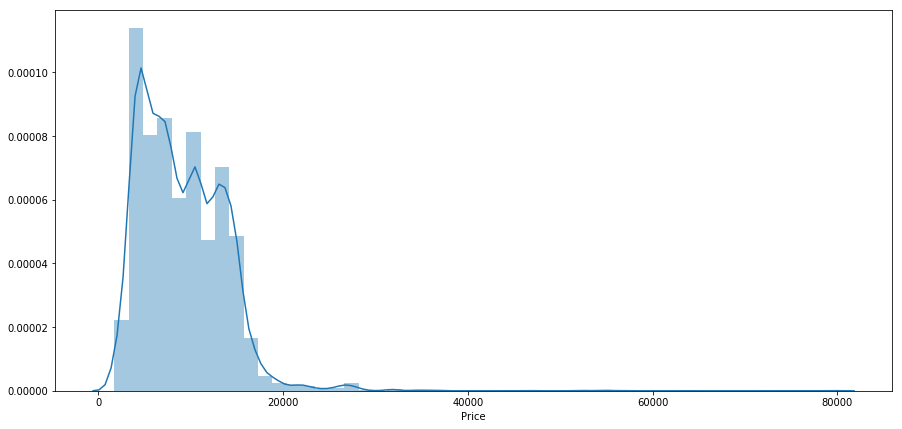

In [51]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(train_df['Price'].sort_values(), ax=ax)
plt.show()

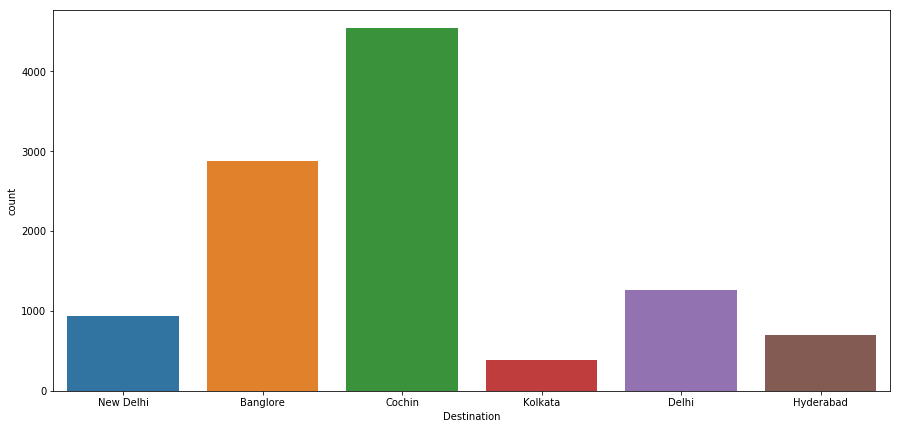

In [52]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(train_df['Destination'])
plt.show()

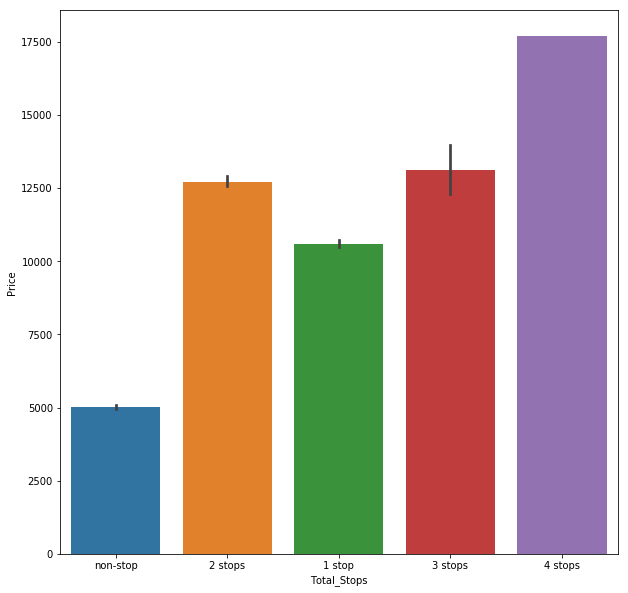

In [64]:
plt.figure(figsize=(10,10))
sns.barplot(y='Price',x='Total_Stops',data=train_df)
plt.show()

In [62]:
train_df.groupby(['Airline']).agg({'Price': 'mean'}).sort_values(by= 'Price', ascending = False).head()

,Price
Airline,
Jet Airways Business,58358.666667
Jet Airways,11643.923357
Multiple carriers Premium economy,11418.846154
Multiple carriers,10902.678094
Air India,9612.427756


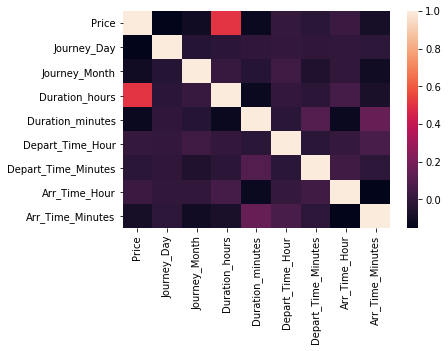

In [65]:
heat_map = sns.heatmap(train_df.corr())

In [66]:
# Dependent Variable
Y_train = train_df.iloc[:,6].values  # 6 is the index of "Price" in the Training Set 

# Independent Variables
X_train = train_df.iloc[:,train_df.columns != 'Price'].values # selects all columns except "Price"

# Independent Variables for Test Set
X_test = test_df.iloc[:,:].values

In [67]:
from sklearn.preprocessing import LabelEncoder

le1 = LabelEncoder()
le2 = LabelEncoder()

In [68]:
# Training Set    

X_train[:,0] = le1.fit_transform(X_train[:,0])

X_train[:,1] = le1.fit_transform(X_train[:,1])

X_train[:,2] = le1.fit_transform(X_train[:,2])

X_train[:,3] = le1.fit_transform(X_train[:,3])

X_train[:,4] = le1.fit_transform(X_train[:,4])

X_train[:,5] = le1.fit_transform(X_train[:,5])

In [69]:
# Test Set

X_test[:,0] = le2.fit_transform(X_test[:,0])

X_test[:,1] = le2.fit_transform(X_test[:,1])

X_test[:,2] = le2.fit_transform(X_test[:,2])

X_test[:,3] = le2.fit_transform(X_test[:,3])

X_test[:,4] = le2.fit_transform(X_test[:,4])

X_test[:,5] = le2.fit_transform(X_test[:,5])

In [70]:
#data after encoding
print(pd.DataFrame(X_train).head())

  0  1  2    3  4  5   6  7   8   9   10  11  12  13
0  3  0  5   18  4  8  24  3   2  50  22  20   1  10
1  1  3  0   84  1  8   1  5   7  25   5  50  13  15
2  4  2  1  118  1  8   9  6  19   0   9  25   4  25
3  3  3  0   91  0  8  12  5   5  25  18   5  23  30
4  3  0  5   29  0  8   1  3   4  45  16  50  21  35


# Feature Scaling

In [71]:
# Feature Scaling


sc_X = StandardScaler()

X_train = sc_X.fit_transform(X_train)

X_test = sc_X.transform(X_test)

#sc_y = StandardScaler()

Y_train = Y_train.reshape((len(Y_train), 1)) 

Y_train = sc_X.fit_transform(Y_train)

Y_train = Y_train.ravel()

In [73]:
print(pd.DataFrame(X_train).head()) # Xtrain after scaling

         0         1         2         3         4         5         6   \
0 -0.410805 -1.658359  2.416534 -1.547082  1.407210  0.499921  1.237288   
1 -1.261152  0.890014 -0.973812  0.249946 -0.253703  0.499921 -1.475307   
2  0.014369  0.040556 -0.295743  1.175687 -0.253703  0.499921 -0.531796   
3 -0.410805  0.890014 -0.973812  0.440539 -0.807341  0.499921 -0.177979   
4 -0.410805 -1.658359  2.416534 -1.247577 -0.807341  0.499921 -1.475307   

         7         8         9         10        11        12        13  
0 -1.467402 -0.970614  1.279041  1.654154 -0.234950 -1.800436 -0.890014  
1  0.250289 -0.381999 -0.196319 -1.303113  1.363607 -0.050909 -0.587094  
2  1.109135  1.030677 -1.671678 -0.607286  0.031476 -1.363054  0.018745  
3  0.250289 -0.617445 -0.196319  0.958326 -1.034229  1.407030  0.321664  
4 -1.467402 -0.735168  0.983969  0.610412  1.363607  1.115442  0.624584  


In [74]:
print(pd.DataFrame(Y_train).head())

          0
0 -1.125535
1 -0.309068
2  1.039783
3 -0.622209
4  0.914006


# Modeling

In [75]:
from sklearn.svm import SVR

svr = SVR(kernel = "rbf")

svr.fit(X_train,Y_train)

Y_pred = sc_X.inverse_transform(svr.predict(X_test))

In [77]:
pd.DataFrame(Y_pred, columns = ['Price']).to_excel("D:/Downloads/Flight_Ticket_Participant_Datasets/Submission.xlsx", index = False)

In [78]:
print(pd.DataFrame(Y_pred).head())

              0
0  10547.002077
1   6773.635780
2  11482.732670
3  11281.247128
4   4379.175423
